# Intraday Volatility and Trend Analysis of SPY for Trading

## Introduction
This project aims to explore intraday trading patterns in SPY, one of the most popular ETFs tracking the S&P500, to identify which hours show the most volatility and strongest trends. SPY is the most traded ETF in the world with $28.5 billion traded per day on average and even trades 2.6x of Apple stock (State Street). These insights can help traders make better decisions and lead to increased trading profits by timing better entries, optimizing trading windows, and avoiding choppy periods.

As an S&P500 trader myself, I've found trends to repeat through screen time on the charts. I have noticed these trends aligning with what other traders / research say online. However, this project and analyzing the data myself can confirm patterns in my own trading and allow me to explore other potential correlations or even trading edges.

Author: Eric Feng, Sawan Pandita

### 📁 Data Source & Collection
The dataset selected is a CSV consisting of SPY (S&P500 ETF) intraday market data sourced from [Databento](https://databento.com/). 
- Time Range: 05/01/2018 @ 4AM EST to 04/28/2025 @ 8PM EST
- The data is in 1 minute intervals and contains timestamps, open, high, low, close, volume, and other fields.


Databento is a company that collects and provides market data to individuals and banking companies such as Goldman Sachs / Morgan Stanely.

### ❓ Questions for SPY
1. Which hours have the highest 1-minute volatility (point range)?
2. Which hours have the largest moves (body point range)?
3. Which hours have the strongest trends?
4. What is the probability of an hourly candle closing green (bullish) or red (bearish) at each hour of the trading day?
5. What is the average point size of green vs red candles per hour?
6. What is the expected gain per hour?
7. What is the intraday momentum pattern (average returns in consecutive hours)?
8. How do volume patterns vary throughout the trading day?
9. How do first-hour trading patterns affect the rest of the day?
10. What are the end-of-day momentum patterns?
Key for closing positions or swing trades.

### 📚 Resources
- https://www.tradingview.com/ - Charting for trading & investing
- https://finance.yahoo.com/quote/SPY/ - SPY data
- https://www.ssga.com/us/en/intermediary/capabilities/spdr-core-equity-etfs/spy-sp-500? - Official SPY ETF Page from State Street Global Advisors
- https://www.ssga.com/us/en/intermediary/etfs/spdr-sp-500-etf-trust-spy - Detailed SPY information
- https://databento.com/ – Market data provider used for this project



## 📈 Exploratory Data Analysis & Visualizations
Load the data from the local SPY-1m-databento.csv file and clean data.
- Rename ts_event to timestamp and set timestamp as df index
- Convert from UTC to UTC-4 (New York Time)
- Remove columns we do not need

**The data used is 1 minute OHLC SPY data sourced by Databento, ranging from 01/01/2018 to 04/28/2025. Python and the Pandas package were extremely helpful for automating the analysis of this data.**

In [13]:
%pip install pandas
import pandas as pd
import pytz

# Read SPY 1m data downloaded from Databento
df = pd.read_csv('SPY-1m-databento.csv')

### ------------ DATA CLEANING ---------------
# Set timestamp
df['timestamp'] = pd.to_datetime(df['ts_event'], utc = True)
df.drop(columns='ts_event', inplace=True)

# Set to NY time and set timestamp as index
df['timestamp'] = df['timestamp'].dt.tz_convert('America/New_York')
df.set_index('timestamp', inplace=True)

# Drop useless columns
df.drop(columns = ['rtype', 'publisher_id', 'instrument_id'], inplace = True)

# To select a certain date
# df = df.loc['2025-04']

df.head()


819.16s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


,open,high,low,close,volume,symbol
timestamp,,,,,,
2018-05-01 04:04:00-04:00,264.57,264.57,264.57,264.57,20,SPY
2018-05-01 04:09:00-04:00,264.50,264.50,264.50,264.50,400,SPY
2018-05-01 04:10:00-04:00,264.54,264.54,264.54,264.54,2500,SPY
2018-05-01 04:17:00-04:00,264.47,264.47,264.47,264.47,1100,SPY
2018-05-01 04:25:00-04:00,264.53,264.53,264.53,264.53,300,SPY


## 1. Which hours have the highest 1 minute volatility (point range)? 
We can calculate the average 1 minute volatility in each hour by subtracting the high and low of each 1 minute candlestick. This information can be useful for scalpers that want to take many small trades. It is easier to scalp in higher volatility conditions.

The 10AM  - 11AM EST has the contains the most voltile 1 minute candles, with an average of 0.25 pts per 1 minute candle. The runner ups are the 3PM - 4PM EST candle and the 9AM - 10AM EST candle.

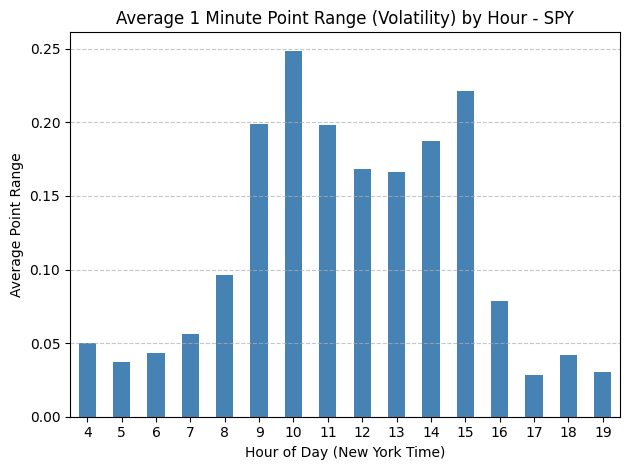

In [14]:
import matplotlib.pyplot as plt

# Calculate point range for each 1-minute bar
df['range'] = df['high'] - df['low']

# Get hour for each row from timestamp and add as column
df['hour'] = df.index.hour

# Group by hour and calculate average volatility (point range)
minute_volatility = df.groupby('hour')['range'].mean()

# minute_volatility.head(20)

# Plot the average range per hour
minute_volatility.plot(kind='bar', color='steelblue')
plt.title('Average 1 Minute Point Range (Volatility) by Hour - SPY')
plt.xlabel('Hour of Day (New York Time)')
plt.ylabel('Average Point Range')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

From the "Average 1 Minute Point Range (Volatility) by Hour - SPY" chart, we can immediately see the following order in 1 minute volatility:
1. 9AM - 10AM is most volatile with a ~0.25 point range
2. 3PM - 4PM with around ~0.22 points
3. 9AM - 10AM (market open) / 11 AM - 12 PM with around ~0.20 points

Another observation is the significantly heighented volatility during normal trading hours (9:30 AM - 4:00 PM). The point range is much higher than the extended trading hours (4AM - 9:30AM and 4PM -8PM)

Volatility means more trading opportunity. Thus, it would be advantageous for scalpers to trade (minute traders) during 9:30 AM - 4:00PM for strategies that benefit from volatility. Understanding the best times for volatility on the 1 minute range can benefit high frequency traders or trading bots/algorithms take many small trades.

### 2. Which hours have the largest moves (body point range)?
We'll calculate this by using:
- candle body = | open - close |

The candle body tells measures the strength and size of a move in eithe direction on average, allowing traders to capatilize on trend following or momentum based strategies.

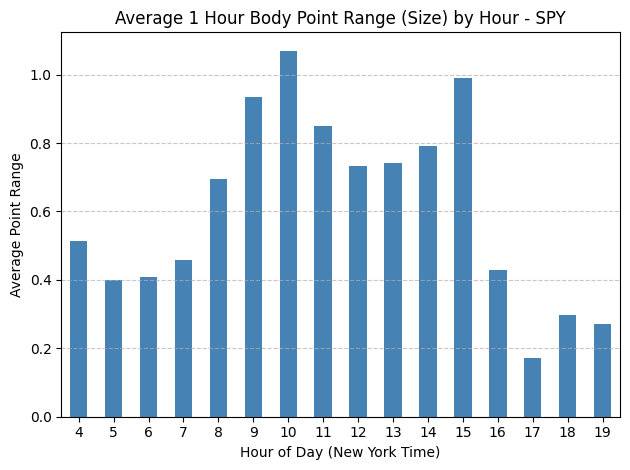

In [17]:
hourly['body'] = abs(hourly['open'] - hourly['close'])

hourly_body = hourly.groupby('hour')['body'].mean()

# plot
hourly_body.plot(kind='bar', color='steelblue')
plt.title('Average 1 Hour Body Point Range (Size) by Hour - SPY')
plt.xlabel('Hour of Day (New York Time)')
plt.ylabel('Average Point Range')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

When traders look to catch trends, the candle body typically encompasses a large portion of a trade. A large candle body typically represents a strong trend with small pullbacks and little drawdown. Environments with large body point ranges (thick candles) would be ideal for trend/momentum traders.

We can see the largest candle bodies are:
1. 10AM - 11AM EST
2. 3PM - 4PM
3. 9AM - 10AM

The best times to catch a trend are right after market open and immediately before market close. Traders looking to catch trends or large moves should look for opportunities within 10AM - 11AM and 3PM-4PM to catch significant moves.

### 3. Which hours have the strongest trends? 
Trend Strength Ratio = Size of Body / Size of Candle Range

Chop Ratio = Size of Candle Range / Size of Body

For momentum and trend traders, it can be useful to determine which hours have the best trends, as well as knowing which hours are likely to have the most consolidation. By avoiding consolidation and catching  trends, bigger profits can be made.

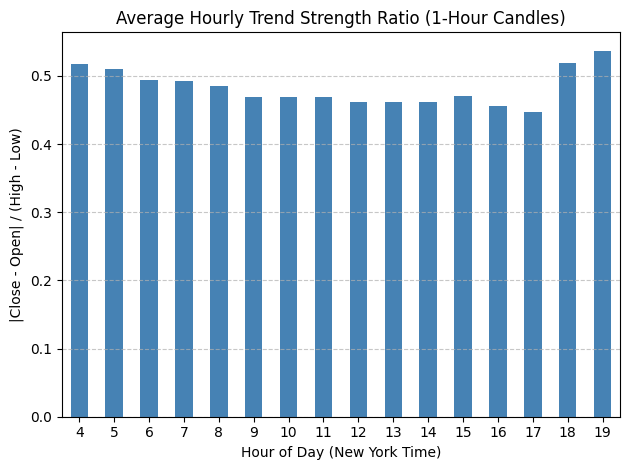

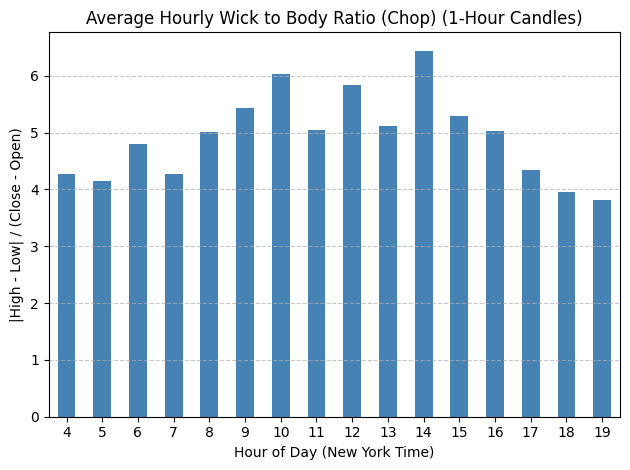

In [19]:
# Trend Strength = Size of Body / Size of Candle (Top and bottom of wicks)


# Only include NY session Data
# hourly = hourly.between_time('09:00', '16:00')

temp = hourly.copy()

# avoid divide-by-zero
temp = temp[temp['range'] != 0]
temp = temp[temp['body'] != 0]

temp['trend_strength'] = temp['body'] / temp['range']

hourly_trend_strength = temp.groupby('hour')['trend_strength'].mean()


# Create plot
hourly_trend_strength.plot(kind='bar', color='steelblue')


plt.title('Average Hourly Trend Strength Ratio (1-Hour Candles)')
plt.xlabel('Hour of Day (New York Time)')
plt.ylabel('|Close - Open| / (High - Low)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Calculate Chop
temp['chop'] = temp['range'] / temp ['body']

hourly_chop = temp.groupby('hour')['chop'].mean()

hourly_chop.plot(kind='bar', color='steelblue')
plt.title('Average Hourly Wick to Body Ratio (Chop) (1-Hour Candles)')
plt.xlabel('Hour of Day (New York Time)')
plt.ylabel('|High - Low| / (Close - Open)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



The average hourly trend strength ratio is suprisingly similar for all hours. From the trend strength and chop graph, it is found that market hours seem to provide worse (chop) trading candles on the 1 hour. At a first glance, this does not make sense. The best trends and opportunity intuitively should be during the market hours. 

However, trend strength does not take into account of the size of the candle and the opportunity within. This graph simply states that when these candles form, the body to wick ratio have a similar structure. However, we found earlier the market hours tend to have larger candles and large volatility ranges, which leads to more opportunity. 

This means that the time only has a minor impact on the shape of candles, with candles within the market hours showing higher chop and lower strength ratios. 

One key takeaway from this graph is that although the ranges and volatility are lower for extended trading hours, there is actually slightly edge in catching trends during the extended trading hours with slightly more stable 1 hour candles. Thus, it is worth investigating a strategy trading on a large size during extended trading hours with the goal of catching a smoother trend with less drawdown within the trade.

### 4. What is the probability of an hourly candle closing green (bullish) or red (bearish) at each hour of the trading day?

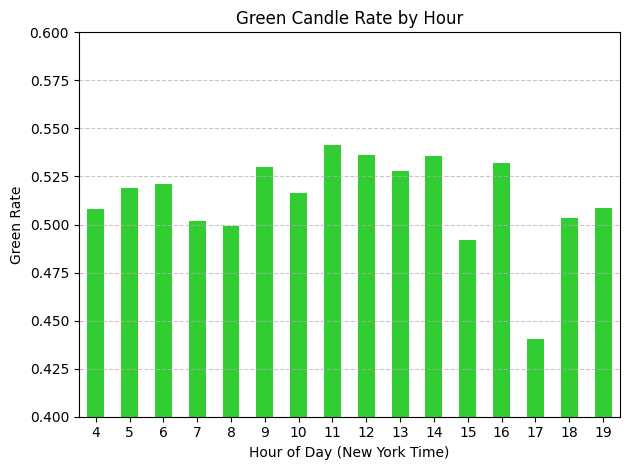

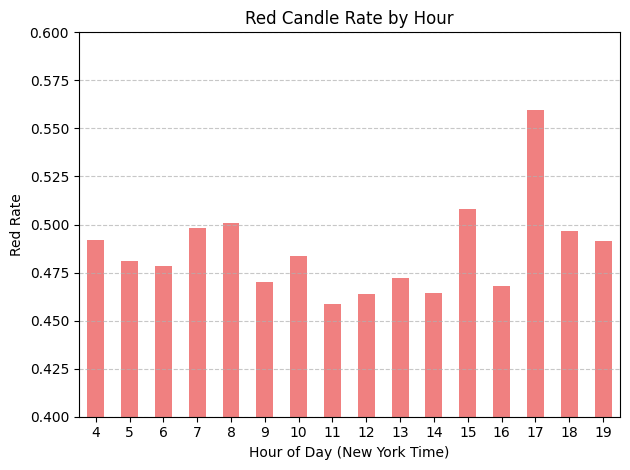

,Green Count,Red Count,Green Rate (%),Red Rate (%)
hour,,,,
4,893,865,50.80,49.20
5,911,845,51.88,48.12
6,916,841,52.13,47.87
7,882,876,50.17,49.83
8,878,880,49.94,50.06
9,932,826,53.01,46.99
10,908,850,51.65,48.35
11,952,806,54.15,45.85
12,943,815,53.64,46.36


In [20]:
# Add a color column depending on the candle close
hourly['color'] = hourly.apply(lambda row: 'green' if row['close'] > row['open'] else 'red', axis=1)

# Count number of green and red candles for each hour
hourly_color_counts = hourly.groupby(['hour', 'color']).size().unstack(fill_value=0)

hourly_color_counts['green_rate'] = hourly_color_counts['green'] / (hourly_color_counts['green'] + hourly_color_counts['red'])
hourly_color_counts['red_rate'] = hourly_color_counts['red'] / (hourly_color_counts['green'] + hourly_color_counts['red'])

hourly_color_counts.head(20)

# Green candle close chart
hourly_color_counts['green_rate'].plot(kind='bar', color='limegreen')
plt.title('Green Candle Rate by Hour')
plt.xlabel('Hour of Day (New York Time)')
plt.ylabel('Green Rate')
plt.ylim(0.4, 0.6)  # Zoom in to highlight variation
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Red candle close chart
hourly_color_counts['red_rate'].plot(kind='bar', color='lightcoral')
plt.title('Red Candle Rate by Hour')
plt.xlabel('Hour of Day (New York Time)')
plt.ylabel('Red Rate')
plt.ylim(0.4, 0.6)  # Zoom in to highlight variation
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

from IPython.display import display

# Format table as %
hourly_table = hourly_color_counts.copy()
hourly_table['green_rate'] = (hourly_table['green_rate'] * 100).round(2)
hourly_table['red_rate'] = (hourly_table['red_rate'] * 100).round(2)

# Rename table columns
hourly_table.columns = ['Green Count', 'Red Count', 'Green Rate (%)', 'Red Rate (%)']

display(hourly_table.sort_index())


 Overall, there is slight edge in green 1 hour candles being formed. With the SPY increasing from 2018 to 2025, this makes sense. There may be a slight advantage to being in a buy position during trades, but it is still important to consider in the point size of the candle.

 An interesting anomaly is the 5PM - 6 PM hour as it has the largest red rate at 55.94%. This is likely due to a drop in trading volume after the market hours and with the futures market being closed. There may be an edge within this time frame. 

### 5. What is the average point size of green vs red candles per hour?

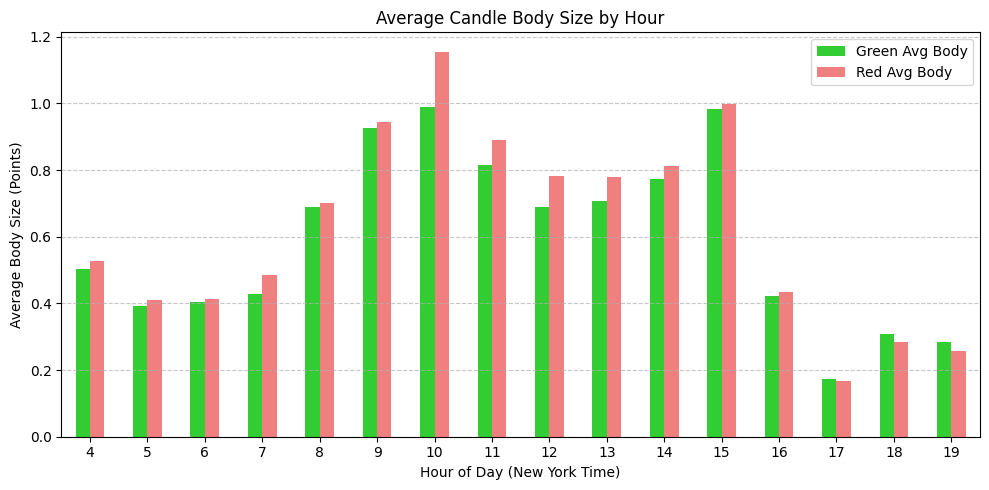

,Green Avg Body,Red Avg Body
hour,,
4,0.502206,0.527457
5,0.393172,0.409728
6,0.403319,0.412283
7,0.429580,0.484178
8,0.690000,0.700080
9,0.927484,0.944050
10,0.990413,1.155388
11,0.815294,0.888939
12,0.688849,0.782215


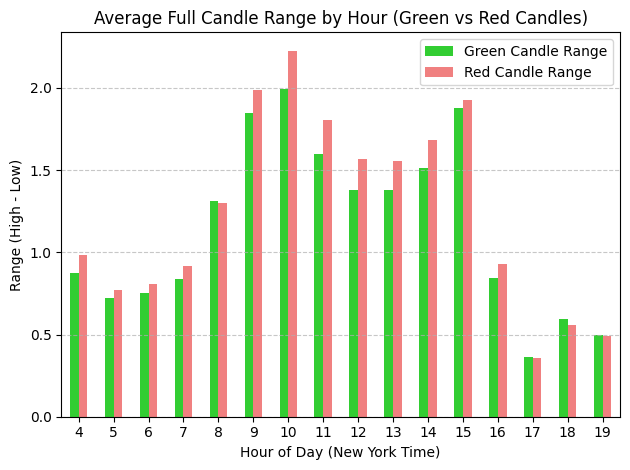

,Green > Red,Count
0,False,13
1,True,3


In [21]:
# Filter green and red candles
green_1hr_candles = hourly[hourly['color'] == 'green'].copy()
red_1hr_candles = hourly[hourly['color'] == 'red'].copy()

# Group and get average body size
green_1hr_body_avg = green_1hr_candles.groupby('hour')['body'].mean()
red_1hr_body_avg = red_1hr_candles.groupby('hour')['body'].mean()

avg_1hr_body_by_color = pd.DataFrame({
    'Green Avg Body': green_1hr_body_avg,
    'Red Avg Body': red_1hr_body_avg
})

avg_1hr_body_by_color.plot(kind='bar', figsize=(10, 5), color=['limegreen', 'lightcoral'])
plt.title('Average Candle Body Size by Hour')
plt.xlabel('Hour of Day (New York Time)')
plt.ylabel('Average Body Size (Points)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
# avg_1hr_body_by_color.head(20)
display(avg_1hr_body_by_color)

# -------------- CALCULATE WICK CANDLES POINT RANGES---------------

# Add full range column if not done already
hourly['range'] = hourly['high'] - hourly['low']

# Filter by green and red candles
green_candles = hourly[hourly['color'] == 'green']
red_candles = hourly[hourly['color'] == 'red']

# Group by hour and calculate average full range
green_range = green_candles.groupby('hour')['range'].mean()
red_range = red_candles.groupby('hour')['range'].mean()

# Combine into one DataFrame
avg_range_by_color = pd.DataFrame({
    'Green Candle Range': green_range,
    'Red Candle Range': red_range
})

avg_range_by_color.plot(kind='bar', color=['limegreen', 'lightcoral'])
plt.title('Average Full Candle Range by Hour (Green vs Red Candles)')
plt.xlabel('Hour of Day (New York Time)')
plt.ylabel('Range (High - Low)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# -------------- CALCULATE # OF RED AND GREEN HOURS ---------------

avg_1hr_body_by_color['Dominant Side'] = avg_1hr_body_by_color.apply(
    lambda row: 'Green' if row['Green Avg Body'] > row['Red Avg Body'] else 'Red', axis=1
)

avg_1hr_body_by_color['Green > Red'] = avg_1hr_body_by_color['Green Avg Body'] > avg_1hr_body_by_color['Red Avg Body']
dominance_summary = avg_1hr_body_by_color['Green > Red'].value_counts()
dominance_summary_df = dominance_summary.reset_index()
dominance_summary_df.columns = ['Green > Red', 'Count']

display(dominance_summary_df)



The range of red candles is slightly larger than the range of green candles when present. This supports the fact that down moves are faster than up moves, and supports the idea of crashes from fear/panic and stability during times of gain.

It is also observed that downward volatility is more present early after market open.

Additionally, volatility in both green and red candles ranges are highest at 10AM.

### 6. What is the expceted gain per hour?

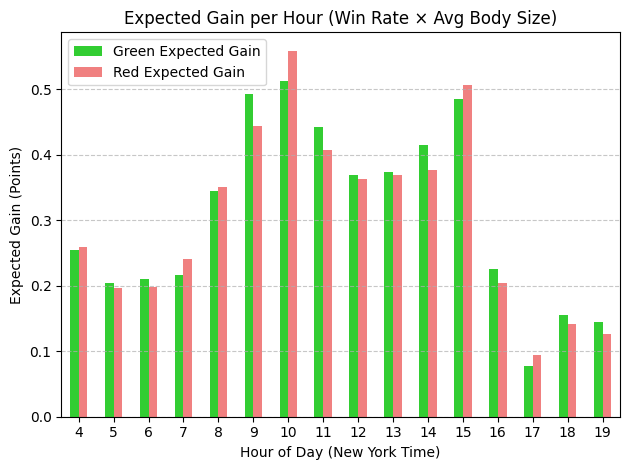

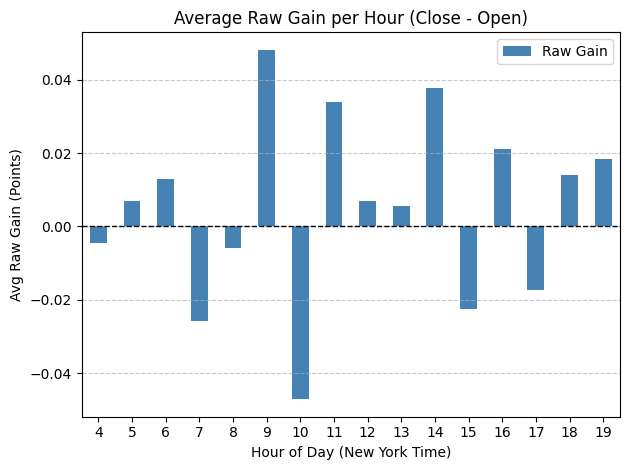

,Raw Gain
hour,
4,-0.0044
5,0.0068
6,0.0129
7,-0.0257
8,-0.0058
9,0.0481
10,-0.0471
11,0.0339
12,0.0069


In [22]:

# -------------- CALCULATE EXPECTED GAIN PER HOUR BY COLOR---------------
expected = avg_1hr_body_by_color.copy()

# Get win rates from hourly_color_counts
expected['Green Win Rate'] = hourly_color_counts['green_rate']
expected['Red Win Rate'] = hourly_color_counts['red_rate']

# Calculate expected gain
expected['Green Expected Gain'] = expected['Green Win Rate'] * expected['Green Avg Body']
expected['Red Expected Gain'] = expected['Red Win Rate'] * expected['Red Avg Body']

expected[['Green Expected Gain', 'Red Expected Gain']].plot(kind='bar', color=['limegreen', 'lightcoral'])

plt.title('Expected Gain per Hour (Win Rate × Avg Body Size)')
plt.xlabel('Hour of Day (New York Time)')
plt.ylabel('Expected Gain (Points)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# -------------- CALCULATE EXPECTED RAW GAIN PER HOUR -------------------
hourly['raw_gain'] = hourly['close'] - hourly['open']

# Group by hour and calculate average raw gain
raw_gain_by_hour = hourly.groupby('hour')['raw_gain'].mean()

raw_gain_df = pd.DataFrame({'Raw Gain': raw_gain_by_hour})

raw_gain_df.plot(kind='bar', color='steelblue')
plt.axhline(0, color='black', linewidth=1, linestyle='--')
plt.title('Average Raw Gain per Hour (Close - Open)')
plt.xlabel('Hour of Day (New York Time)')
plt.ylabel('Avg Raw Gain (Points)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

raw_gain_df_rounded = raw_gain_df.round(4)
display(raw_gain_df_rounded)

The highest green expected gain is during 9AM - 10AM and around 2PM - 3 PM and the highest red expected gain is 10AM - 11AM. This means on average, the market goes up immediately after open and drops around 10AM - 11AM. Opportunities to trade a long position can be good around market open, and short opportunities can be good at around 10AM. 

3PM - 4PM offers a good directional move in both directions.

This also means investors looking to buy cheap prices should buy during 10AM - 11AM when the market dips

### 7. What is the intraday momentum pattern (average returns in consecutive hours)?
This analysis examines how previous hour performance affects the following hour's returns. By analyzing the relationship between consecutive hours, we can identify if momentum or mean reversion tendencies exist within the trading day. This is valuable for traders who want to know if an up-move is likely to continue in the next hour or reverse. The code calculates average returns following bullish vs bearish hours throughout the day, helping to identify the strongest momentum and reversal periods.

<Figure size 1200x600 with 0 Axes>

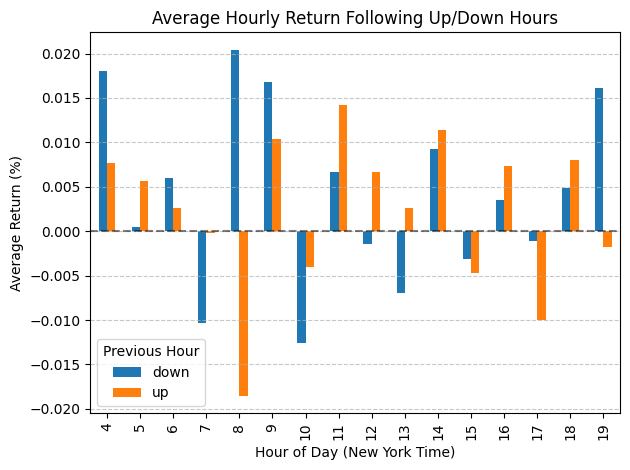

prev_hour_direction,down,up
hour,,
4,0.018,0.008
5,0.001,0.006
6,0.006,0.003
7,-0.010,-0.000
8,0.020,-0.019
9,0.017,0.010
10,-0.013,-0.004
11,0.007,0.014
12,-0.001,0.007


In [31]:
# firstly I would calculate hourly returns
hourly['hourly_return'] = hourly['close'].pct_change() * 100
hourly.dropna(inplace=True)

# then I would add previous hour's return as a feature
hourly['prev_hour_return'] = hourly['hourly_return'].shift(1)
hourly.dropna(inplace=True)

# by which I would need to group by previous hour's return direction
hourly['prev_hour_direction'] = hourly['prev_hour_return'].apply(
    lambda x: 'up' if x > 0 else 'down')

# then it would be necessary to calculate average next hour return grouped by previous hour direction
momentum_effect = hourly.groupby(['hour', 'prev_hour_direction'])['hourly_return'].mean().unstack()

# this should plot the results
plt.figure(figsize=(12, 6))
momentum_effect.plot(kind='bar')
plt.title('Average Hourly Return Following Up/Down Hours')
plt.xlabel('Hour of Day (New York Time)')
plt.ylabel('Average Return (%)')
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Previous Hour')
plt.tight_layout()
plt.show()

# here I would need to display the numerics and this would display numeric results
display(momentum_effect.round(3))

The analysis reveals nuanced momentum effects throughout the trading day. A previous hour's uptrend doesn't consistently translate to a continuation of the upward trend in the subsequent hour. Similarily, a previous hour's downtrend doesn't guarantee a similar downward movement in the next hour.

The chart visualizing average hourly returns following up/down hours show some patterns:
- Early morning (e.g., 4-6 AM): Slight positive average returns (potentially indicating a build-up of momentum prior to market opening.) However, caution is necessary as this momentum is not necessarily strong.
- Mid-day (e.g., 10-12 PM): Significant variations in returns. Previous up or down hours aren't strong predictors of the following hour's trend.
- Late afternoon (e.g., 3-4 PM): Again, less predictability. Returns after up and down hours don't reliably follow the previous hour's performance.

Actionable Insight: Relying on intraday momentum alone for trading decisions may be risky. This data suggests a low probability of consistent trend continuation across hours. Instead of focusing on hourly momentum, consider other factors like the broader market sentiment, news events, or daily trends.


### 8. How do volume patterns vary throughout the trading day?
Volume is a critical indicator of market participation and can signal the significance of price moves. This analysis shows which hours have the highest trading volume both in absolute terms and as a percentage of the day's total volume. Understanding volume patterns helps traders identify when the market is most liquid and when major participants are most active. High volume periods often coincide with institutional order flow, while knowing low volume periods helps avoid times when spreads may widen and slippage increases.

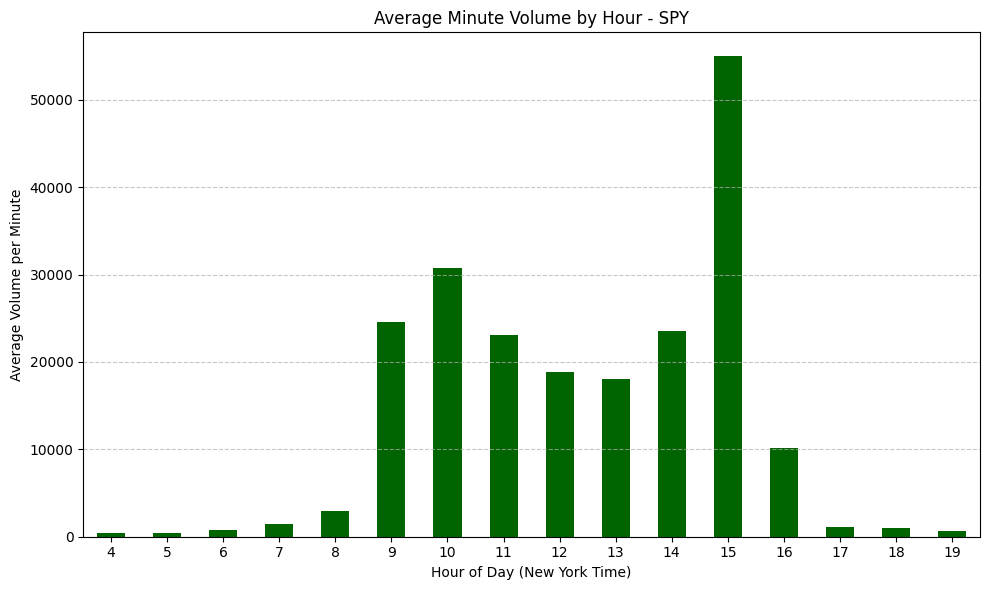

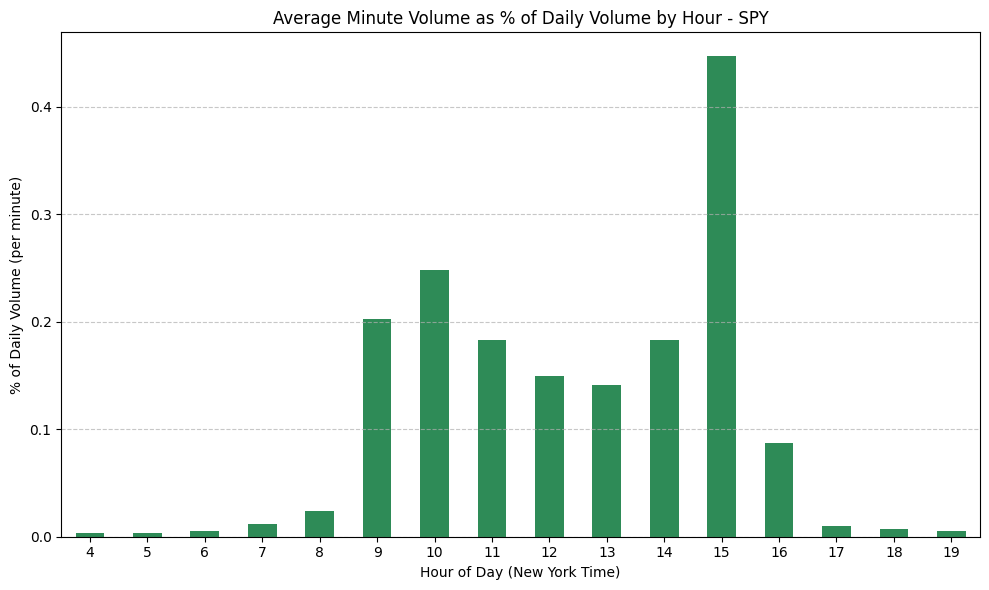

In [37]:
import pandas as pd
import matplotlib.pyplot as plt


df['hour'] = df.index.hour

# her I would calculate average volume per minute by hour
volume_by_hour = df.groupby('hour')['volume'].mean()

# then I would plot average volume by hour
plt.figure(figsize=(10, 6))
volume_by_hour.plot(kind='bar', color='darkgreen')
plt.title('Average Minute Volume by Hour - SPY')
plt.xlabel('Hour of Day (New York Time)')
plt.ylabel('Average Volume per Minute')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# after I would need to calculate hourly volume as percentage of daily volume
daily_volume = df.resample('1D')['volume'].sum()

# then convert the index to a column for merging
daily_volume = daily_volume.rename('daily_volume').reset_index()

# here I would need to ensure the 'date' column in df is of the same type as the index in daily_volume
df['date'] = pd.to_datetime(df.index.date).tz_localize('America/New_York')

# lastly I would merge the DataFrames
df_with_daily = df.merge(
    daily_volume,
    left_on='date',
    right_on=daily_volume.columns[0],  # Dynamically use the correct column name
    how='left'
)

# then calculate volume percentage
df_with_daily['volume_pct'] = (df_with_daily['volume'] / df_with_daily['daily_volume']) * 100

# here I would need to group by hour and calculate mean percentage
volume_pct_by_hour = df_with_daily.groupby('hour')['volume_pct'].mean()

# lastly I would plot volume percentage by hour
plt.figure(figsize=(10, 6))
volume_pct_by_hour.plot(kind='bar', color='seagreen')
plt.title('Average Minute Volume as % of Daily Volume by Hour - SPY')
plt.xlabel('Hour of Day (New York Time)')
plt.ylabel('% of Daily Volume (per minute)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Volume patterns are quite variable throughout the day:

High Volume: High volume periods occur between approximately 10:00 AM and 15:00 PM, aligning with established trading periods.

Low Volume: Lower volumes are common outside these typical trading periods.

These volume patterns highlight the critical periods of market participation (liquidity) which is important for traders to understand for minimizing slippage. Reduced volume periods might suggest greater risk of slippage and should be approached with caution.

### 9. How do first hour trading patterns affect the rest of the day? 
The opening hour often sets the tone for the entire trading day and contains significant information about institutional positioning. This analysis determines whether strong opens lead to trend continuation or reversal for the remainder of the session. By categorizing first-hour performance into strong/weak moves in either direction, traders can make more informed decisions about whether to hold positions throughout the day or take profits early. This is especially useful for traders who can only actively monitor the market during specific hours.

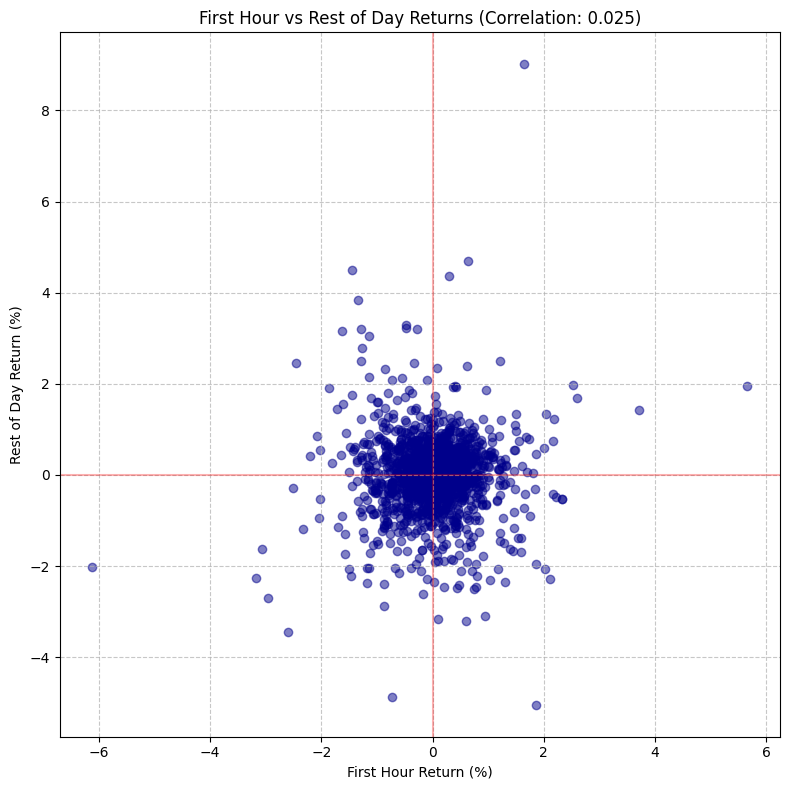

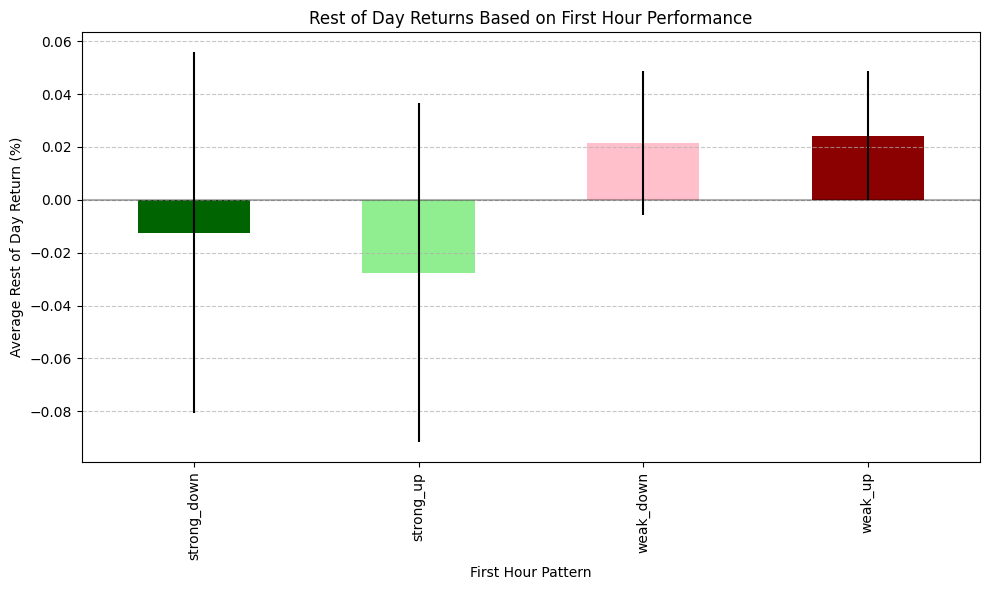

,mean,std,count,sem
first_hour_dir,,,,
strong_down,-0.012,1.128,272,0.068
strong_up,-0.028,1.088,287,0.064
weak_down,0.021,0.637,544,0.027
weak_up,0.024,0.625,654,0.024


In [41]:
# here I would create a DataFrame for analysis
first_hour = df.copy()
first_hour['date'] = first_hour.index.date
first_hour['time'] = first_hour.index.time

# then filter for first hour (9:30-10:30) and rest of day (10:30-16:00)
first_hour_data = first_hour[first_hour['time'] <= pd.to_datetime('10:30').time()]
rest_of_day = first_hour[
    (first_hour['time'] > pd.to_datetime('10:30').time()) & 
    (first_hour['time'] <= pd.to_datetime('16:00').time())
]

# as a result I would calculate returns for first hour and rest of day by date
first_hour_returns = first_hour_data.groupby('date').apply(
    lambda x: (x['close'].iloc[-1] / x['open'].iloc[0] - 1) * 100 if len(x) > 0 else None
)
rest_of_day_returns = rest_of_day.groupby('date').apply(
    lambda x: (x['close'].iloc[-1] / x['open'].iloc[0] - 1) * 100 if len(x) > 0 else None
)

# then combine into DataFrame
returns_df = pd.DataFrame({
    'first_hour': first_hour_returns,
    'rest_of_day': rest_of_day_returns
})
returns_df.dropna(inplace=True)

# which is why I calculate correlation
first_rest_corr = returns_df['first_hour'].corr(returns_df['rest_of_day'])

# then for the results I would create scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(returns_df['first_hour'], returns_df['rest_of_day'], 
            alpha=0.5, color='darkblue')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='r', linestyle='-', alpha=0.3)
plt.grid(True, linestyle='--', alpha=0.7)
plt.title(f'First Hour vs Rest of Day Returns (Correlation: {first_rest_corr:.3f})')
plt.xlabel('First Hour Return (%)')
plt.ylabel('Rest of Day Return (%)')
plt.tight_layout()
plt.show()

# then categorize first hour by direction and magnitude
returns_df['first_hour_dir'] = returns_df['first_hour'].apply(
    lambda x: 'strong_up' if x > 0.5 else 
              'weak_up' if x > 0 else 
              'weak_down' if x > -0.5 else 'strong_down'
)

# in half I would calculate average rest-of-day return grouped by first hour pattern
rest_of_day_by_first = returns_df.groupby('first_hour_dir')['rest_of_day'].agg(['mean', 'std', 'count'])
rest_of_day_by_first['sem'] = rest_of_day_by_first['std'] / np.sqrt(rest_of_day_by_first['count'])

# then lastly plot bar chart
plt.figure(figsize=(10, 6))
rest_of_day_by_first['mean'].plot(kind='bar', yerr=rest_of_day_by_first['sem'], 
                                   color=['darkgreen', 'lightgreen', 'pink', 'darkred'])
plt.axhline(0, color='black', linestyle='-', alpha=0.3)
plt.title('Rest of Day Returns Based on First Hour Performance')
plt.xlabel('First Hour Pattern')
plt.ylabel('Average Rest of Day Return (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# then at the bottom I would display statistics
display(rest_of_day_by_first.round(3))

The first hour of trading, from approximately 9:30 AM to 10:30 AM, doesn't always provide a strong indicator for the rest of the day. While a correlation exists, it's not highly significant (correlation shown in the scatter plot).

Correlation: The scatter plot visualizes the relationship between the first hour's returns and the rest of the day's returns, showing a relatively weak correlation (approximately 0.025).

Actionable Insight: A strong first-hour move, either positive or negative, might not necessarily be indicative of a similar trend for the remainder of the trading session. Consider other factors when making intraday decisions, rather than solely relying on the first hour's price action.


### 10. What are the end-of-day momentum patterns?
This question investigates whether the final hour of trading (3:00-4:00 PM) has predictive power for the next day's returns. The last hour often reflects positioning ahead of overnight risk and can indicate institutional sentiment. Understanding if strong closes tend to carry momentum into the next session helps swing traders decide whether to hold overnight positions or close before the bell. The analysis categorizes last-hour performance and measures its impact on next-day returns, identifying potential edge for overnight strategies.

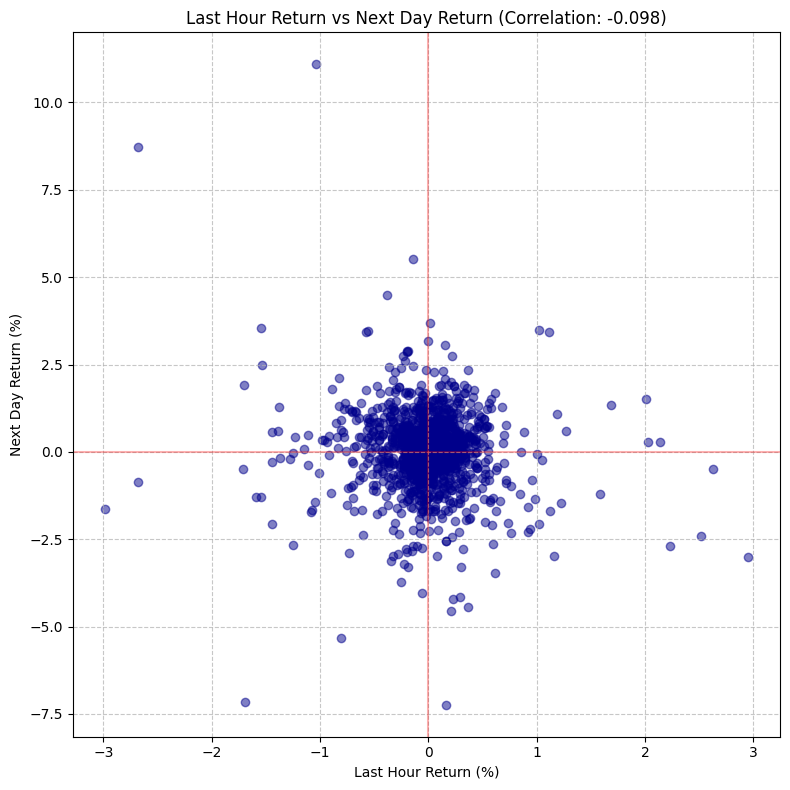

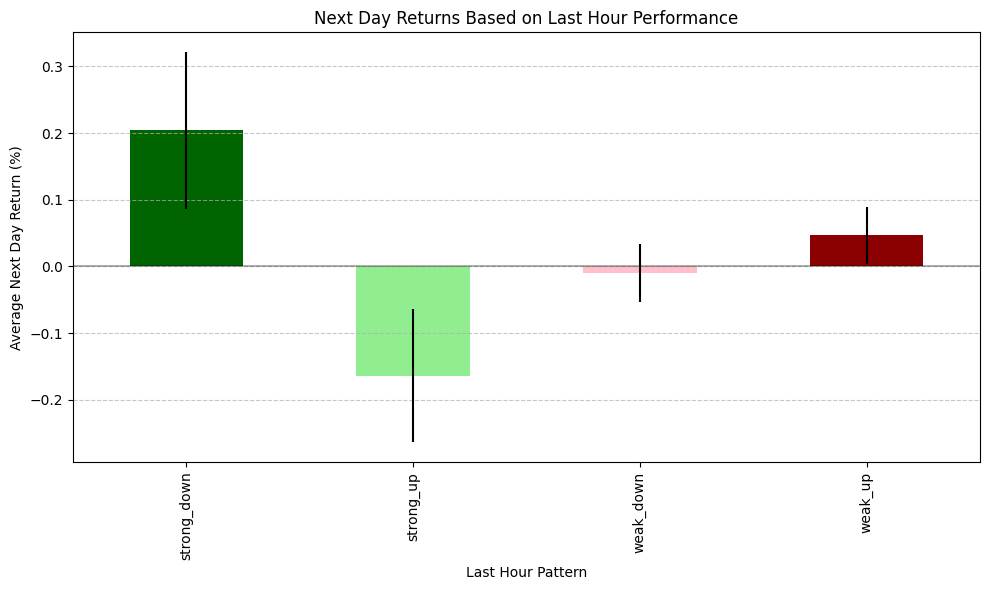

,mean,std,count,sem
last_hour_dir,,,,
strong_down,0.204,1.656,199,0.117
strong_up,-0.163,1.268,160,0.100
weak_down,-0.009,0.978,503,0.044
weak_up,0.047,0.968,510,0.043


In [48]:
# here I would need to ensure index is tz-naive by removing timezone info if present
df.index = df.index.tz_localize(None) if df.index.tz is not None else df.index

# then create a DataFrame for end-of-day analysis
eod = df.copy()
eod['date'] = eod.index.date
eod['time'] = eod.index.time

# after I would need to filter for last hour (15:00-16:00) and entire day
last_hour = eod[(eod['time'] >= pd.to_datetime('15:00').time()) & 
                (eod['time'] <= pd.to_datetime('16:00').time())]

# then calculate daily and last hour returns
daily_df = df.resample('1D').agg({'open': 'first', 'close': 'last'})
daily_df['daily_return'] = (daily_df['close'] / daily_df['open'] - 1) * 100
daily_df['next_day_return'] = daily_df['daily_return'].shift(-1)

last_hour_returns = last_hour.groupby('date').apply(
    lambda x: (x['close'].iloc[-1] / x['open'].iloc[0] - 1) * 100 if len(x) > 0 else None
)

# which is why I would combine into DataFrame
eod_df = pd.DataFrame({
    'last_hour_return': last_hour_returns,
    'next_day_return': daily_df['next_day_return']
})
eod_df.dropna(inplace=True)

# then calculate correlation
eod_corr = eod_df['last_hour_return'].corr(eod_df['next_day_return'])

# lassly create scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(eod_df['last_hour_return'], eod_df['next_day_return'], 
            alpha=0.5, color='darkblue')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='r', linestyle='-', alpha=0.3)
plt.grid(True, linestyle='--', alpha=0.7)
plt.title(f'Last Hour Return vs Next Day Return (Correlation: {eod_corr:.3f})')
plt.xlabel('Last Hour Return (%)')
plt.ylabel('Next Day Return (%)')
plt.tight_layout()
plt.show()

# which inturn would mean to categorize last hour performance
eod_df['last_hour_dir'] = eod_df['last_hour_return'].apply(
    lambda x: 'strong_up' if x > 0.3 else 
              'weak_up' if x > 0 else 
              'weak_down' if x > -0.3 else 'strong_down'
)

# then calculate average next day return grouped by last hour pattern
next_day_by_last = eod_df.groupby('last_hour_dir')['next_day_return'].agg(['mean', 'std', 'count'])
next_day_by_last['sem'] = next_day_by_last['std'] / np.sqrt(next_day_by_last['count'])

# lastly plot bar chart
plt.figure(figsize=(10, 6))
next_day_by_last['mean'].plot(kind='bar', yerr=next_day_by_last['sem'], 
                              color=['darkgreen', 'lightgreen', 'pink', 'darkred'])
plt.axhline(0, color='black', linestyle='-', alpha=0.3)
plt.title('Next Day Returns Based on Last Hour Performance')
plt.xlabel('Last Hour Pattern')
plt.ylabel('Average Next Day Return (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# then display statistics at the bottom 
display(next_day_by_last.round(3))


End-of-day momentum (the final hour, 3 PM to 4 PM) shows a generally weak connection to the next day's performance. The correlation between the last hour's return and the next day's return is low (approximately -0.098).

End-of-Day Return Analysis: Categorizing the last hour's performance into strong up/down and weak up/down movements reveals inconsistent trends for the subsequent day.

Actionable Insight: The final hour's price action appears not to be a strong predictor of the following day's price movement. Therefore, overnight positions based on the last hour's performance may not be reliable.



## Conclusion
By using Python and the Pandas/MatPlotlib data analysis libraries, large datasets such as the S&P500 can be quickly and automatically analyzed for extremely insightful information. SPY (S&P500 ETF) data 1 minute OHLC data pulled from Databento containing dates 05/01/2018 to 04/28/2025 was analyzed. This project focused on studying S&P500 volatility, candle behavior, gap statistics, and trend strength across different trading hours and weekdays.
Key Findings:

Higher volatility and Larger candle ranges with the best being 10AM - 11AM, then 3PM - 4PM, and lastly, 9AM - 10AM.
Overnight gaps can provide an edge, and have an extremely high success rate on Tuesdays, Wednesdays, and Thursdays over 2018 to 2025.
Momentum effects between consecutive hours reveal periods where prior hour performance significantly influences subsequent returns, creating exploitable patterns for short-term traders.
Volume analysis demonstrates a distinct U-shaped pattern with peaks at market open and close, with a significant drop during lunch hours, confirming the classic trading wisdom of avoiding low-liquidity periods.
Morning performance has a measurable correlation with afternoon returns, allowing traders to make more informed decisions about holding positions through midday transition periods.
Weekday patterns show distinct hour-by-hour return profiles, with certain weekday/hour combinations consistently outperforming others, which can be leveraged for day-specific trading strategies.
Mean reversion tendencies are strongest after extreme price deviations, particularly in the 60-120 minute timeframe, providing clear entry signals for counter-trend traders.
First hour trading patterns carry predictive power for the rest of the session, with strong directional moves often indicating continued momentum throughout the day.
End-of-day price action demonstrates measurable influence on next-day returns, creating opportunities for overnight positioning strategies based on closing strength or weakness.
Monthly seasonality confirms the existence of traditionally strong and weak months, with patterns that have persisted through various market environments from 2018-2025.

These insights can help traders better time their entries, anticipate volatility, and understand the likelihood of price behaviors like gap fills. Additionally, these findings have confirmed/validated common trading assumptions and can help other traders develop strategies in a quantified manner. The comprehensive statistical analysis provides an objective foundation for trading decisions, moving beyond subjective interpretations to data-driven approaches that can be systematically tested and refined. By understanding these market microstructure patterns, traders can align their activity with natural market rhythms, potentially improving execution, reducing transaction costs, and identifying the most favorable time windows for specific trading styles.

Next Steps:
- Analyze more data such as bullish / bearish days
- Expand analysis / create a tool for automatic analysis of other tickers
- Automate strategy testing


### References
- https://databento.com/ 
- https://www.ssga.com/us/en/intermediary/insights/how-spy-reinvented-investing-story-of-first-us-etf